## Bi-cubic補完

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

[[ 0.         -0.07407407 -0.14814815 ...  0.         -0.07407407
  -0.14814815]
 [ 0.         -0.07407407 -0.14814815 ...  0.         -0.07407407
  -0.14814815]
 [ 0.         -0.07407407 -0.14814815 ...  0.         -0.07407407
  -0.14814815]
 ...
 [ 0.         -0.07407407 -0.14814815 ...  0.         -0.07407407
  -0.14814815]
 [ 0.         -0.07407407 -0.14814815 ...  0.         -0.07407407
  -0.14814815]
 [ 0.         -0.07407407 -0.14814815 ...  0.         -0.07407407
  -0.14814815]]
[[[ 0.          0.          0.        ]
  [-0.07407407 -0.07407407 -0.07407407]
  [-0.14814815 -0.14814815 -0.14814815]
  ...
  [ 0.          0.          0.        ]
  [-0.07407407 -0.07407407 -0.07407407]
  [-0.14814815 -0.14814815 -0.14814815]]

 [[ 0.          0.          0.        ]
  [-0.07407407 -0.07407407 -0.07407407]
  [-0.14814815 -0.14814815 -0.14814815]
  ...
  [ 0.          0.          0.        ]
  [-0.07407407 -0.07407407 -0.07407407]
  [-0.14814815 -0.14814815 -0.14814815]]

 [[ 0.      

[[ 0.         -0.14814815 -0.07407407 ...  0.         -0.14814815
  -0.07407407]
 [ 0.         -0.14814815 -0.07407407 ...  0.         -0.14814815
  -0.07407407]
 [ 0.         -0.14814815 -0.07407407 ...  0.         -0.14814815
  -0.07407407]
 ...
 [ 0.         -0.14814815 -0.07407407 ...  0.         -0.14814815
  -0.07407407]
 [ 0.         -0.14814815 -0.07407407 ...  0.         -0.14814815
  -0.07407407]
 [ 0.         -0.14814815 -0.07407407 ...  0.         -0.14814815
  -0.07407407]]
[[[ 0.          0.          0.        ]
  [-0.14814815 -0.14814815 -0.14814815]
  [-0.07407407 -0.07407407 -0.07407407]
  ...
  [ 0.          0.          0.        ]
  [-0.14814815 -0.14814815 -0.14814815]
  [-0.07407407 -0.07407407 -0.07407407]]

 [[ 0.          0.          0.        ]
  [-0.14814815 -0.14814815 -0.14814815]
  [-0.07407407 -0.07407407 -0.07407407]
  ...
  [ 0.          0.          0.        ]
  [-0.14814815 -0.14814815 -0.14814815]
  [-0.07407407 -0.07407407 -0.07407407]]

 [[ 0.      

True

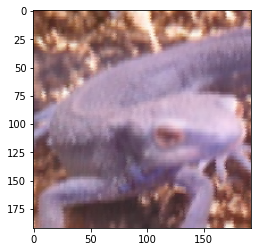

In [6]:
def bc_interpolation(img, ax=1, ay=1):
    H, W, C = img.shape
    
    #拡大したときの画像サイズ
    aH = int(ay*H)
    aW = int(ax*W)
    
    # get positions of resized image
    # ①y座標を表した配列と、x標を表した配列をそれぞれ拡大した画像のサイズで作る
    y = np.arange(aH).repeat(aW).reshape(aH, -1)
    x = np.tile(np.arange(aW), (aH, 1))
    
    # ②座標を拡大率で割り、元の画像上でどこの座標に当たるかを求める
    y = (y/ay)
    x = (x/ax)
    
    # 切り捨てて、I(x, y)に当たる座標を求める→そこから他の15個の座標も求められる
    ix = np.floor(x).astype(np.int)
    iy = np.floor(y).astype(np.int)
    
    # エラー会費用なのだろうか？
    # これ無しで動かすとどうなるか確認する→動く
    ix = np.minimum(ix, W-1)
    iy = np.minimum(iy, H-1)
    
    # get distance of each position of original image
    dx2 = x-ix
    dy2 = y-iy
    dx1 = dx2+1
    dy1 = dy2+1
    dx3 = 1-dx2
    dy3 = 1-dy2
    dx4 = 1+dx3
    dy4 = 1+dy3
    
    # ループで回すためにリストを作っておく
    dxs = [dx1, dx2, dx3, dx4]
    dys = [dy1, dy2, dy3, dy4]
    
    # クロージャ
    # 外側の変数を記憶した関数
    def weight(t):
        a = -1
        at = np.abs(t)
        w = np.zeros_like(t)
        ind = np.where(at<=1)
        w[ind] = ((a+2)*np.power(at, 3) - (a+3)*np.power(at, 2) + 1)[ind]
        ind = np.where((1<at)&(at<=2))
        w[ind] = (a*np.power(at, 3) - 5*a*np.power(at,2) + 8*a*at - 4*a)[ind]
        
        return w
    
    # 重み合計と出力の格納先
    w_sum = np.zeros((aH, aW, C), dtype=np.float32)
    out = np.zeros((aH, aW, C), dtype=np.float)
    
    # interpolate
    for j in range(-1, 3):
        for i in range(-1, 3):
            #ここは何しているの
            ind_x = np.minimum(np.maximum(ix+i, 0), W-1)
            ind_y = np.minimum(np.maximum(iy+j, 0), H-1)
            
            # 重みを計算
            wx = weight(dxs[i+1])
            wy = weight(dys[i+1])
            print(wx)
            
            # 3チャネル分に増やす 
            wx = np.repeat(np.expand_dims(wx, axis=-1), 3, axis=-1)
            wy = np.repeat(np.expand_dims(wy, axis=-1), 3, axis=-1)
            print(wx)
            
            w_sum += wx*wy
            out += wx*wy*img[ind_y, ind_x]
            
    out /= w_sum
    out = np.clip(out, 0, 255)
    out = out.astype(np.uint8)
        
    return out
    
img = cv2.imread('../imori.jpg').astype(np.float32)

out = bc_interpolation(img, ax=1.5, ay=1.5)

plt.imshow(out)
cv2.imwrite('out27.jpg', out)